In [985]:
seed_value = 42

import random
# set python seed
random.seed(seed_value)
from math import log, exp, sqrt, sin, cos, pi
import numpy
# set numpy seed
numpy.random.seed(seed_value)
from numpy import split, array, arctan, mean, zeros, sin, cos, pi, arange, concatenate

import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow
# set tf seed
tensorflow.random.set_seed(seed_value)
from tensorflow.keras import backend as K
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, GRU
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed, Bidirectional, Dropout

import matplotlib
from matplotlib import pyplot

pyplot.style.use('ggplot')

from IPython.display import Image 
import datetime, os

# Load the TensorBoard notebook extension
#%load_ext tensorboard
pyplot.rcParams['figure.dpi'] = 100
pyplot.rcParams['figure.figsize'] = [12,5]
matplotlib.rc('lines', linewidth=1, linestyle='-')

In [986]:
#%reload_ext tensorboard

In [987]:
# MAAPE metric -> does not have the same behaviour as MAPE for actual values close to zero, which is good

def mean_arctangent_absolute_percentage_error(actual, predicted):

    return mean(arctan(abs((actual - predicted) / actual))) * 100

In [988]:
# train the model
def build_model(train, n_input, n_output, stride, units=64, epochs=150, batch_size=0, shuffle=True):
    # prepare data
    train_x, train_y = to_supervised(train, n_input, n_output, stride)
    # Model variables
    verbose = 1 #batch_size 1 IS SGD, 1<BATCH_SIZE<SIZE IS MINIBATCH GD AND BATCH_SIZE=SIZE IS BATCH GD
    n_timesteps, n_features = train_x.shape[1], train_x.shape[2]
    
    # final data preparation for the model
    # reshape train_output into [samples, timesteps, features] for the LSTMs
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1], 1)
    
    # define model
    model = Sequential()
    
    # BIDIRECTIONAL
    """
    model.add(Bidirectional(LSTM(256, activation='tanh', input_shape=(n_timesteps, n_features))))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(n_output))
    """

    # DEEPER LSTM
    """
    model.add(LSTM(units, activation='tanh', input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(units, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(n_output))
    """
    
    # TIMEDISTRIBUTED LSTM
    """
    model.add(LSTM(units, activation='tanh', input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    """
    # VANILLA LSTM
    
    model.add(GRU(units, activation='tanh', input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(GRU(units, activation='tanh'))
    model.add((Dense(n_output)))
    
    
    # SEQ2SEQ LSTM
    """
    model.add(LSTM(units, activation='tanh', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_output))
    model.add(LSTM(units, activation='tanh', return_sequences=True))   # Reminder: Other activation fuctions?
    model.add(TimeDistributed(Dense(1)))
    """
    # STATEFUL LSTM
    """
    model.add(LSTM(n_output, batch_input_shape=(batch_size, train_x.shape[1], train_x.shape[2]), stateful=True))
    #model.add(Dense(n_output))
    model.compile(loss="mse", optimizer='adam')  # can be "mse" and the functions on top
    for i in range(epochs):
        model.fit(train_x, train_y, epochs=1, batch_size=batch_size, verbose=verbose, shuffle=False)
        model.reset_states()
    """
    model.compile(loss="mse", optimizer='adam', metrics=["mae"])  #Reminder: LOSS function is MSE but others can be used!
    
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))  
    #tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=15)

    # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[early]) #tensorboard_callback,
    print(model.summary())
    pyplot.plot(history.history['loss'])
    pyplot.show()
    return model

In [989]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    # Plot rolling statistics:
    orig = pyplot.plot(timeseries, color='blue', label='Original')
    mean = pyplot.plot(rolmean, color='red', label='Rolling Mean')
    std = pyplot.plot(rolstd, color='black', label='Rolling Std')
    pyplot.legend(loc='best')
    pyplot.title('Rolling Mean & Standard Deviation')
    pyplot.show(block=False) 

    # Perform the augmented Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [990]:
# load the csv file
# ../old_data//30min/30minstore290.csv
# ../old_data/30min/30minstore1027.csv
# ../30min/30minstore274.csv
# special case01: ../old_data/30min/partial_covid_stationary_sliced_30minstore274.csv
# special case02: ../old_data/30min/full_covid_nonstationary_sliced_30minstore274.csv
# predict covid:  ../old_data/30min/predict_covid_30minstore274


# NEW STORES
# ../Treatment/imputed_stores/linear_interp_store0057.csv
# ../Treatment/new_stores/store_0057.csv

# ../Treatment/imputed_stores/linear_interp_store4969.csv
# ../Treatment/new_stores/store_4969.csv




# IMPUTED DATASET
dataset = pd.read_csv('../Treatment/imputed_stores/hourly_linear_interp_store0051_true_schedules.csv', header=0, infer_datetime_format=True,parse_dates=['ds'], index_col=['ds'])

# NORMAL DATASET
#dataset = pd.read_csv('../Treatment/new_stores/store_0057.csv', header=0, infer_datetime_format=True,parse_dates=['ds'], index_col=['ds'])
slice_dataset = 3930
dataset = dataset[:-slice_dataset]
print(dataset)

                     n_clients imputed
ds                                    
2015-01-02 09:00:00       82.0     yes
2015-01-02 10:00:00       82.0      no
2015-01-02 11:00:00      100.0      no
2015-01-02 12:00:00      127.0      no
2015-01-02 13:00:00      162.0      no
...                        ...     ...
2019-11-30 19:00:00      100.0      no
2019-11-30 20:00:00       96.0      no
2019-11-30 21:00:00       47.0      no
2019-11-30 22:00:00       47.0     yes
2019-11-30 23:00:00       47.0     yes

[22305 rows x 2 columns]


In [991]:
# PARAMETERS
dataset_day = 15             # nr of samples in a day
n_input = dataset_day*1                # steps used to predict (autoregressive order) p
n_output = 1              # steps to predict (forecast horizon) H
test_set = dataset_day*60              # last observations for the test_set
data_split = test_set        # to split the data in windows
stride = 1                   # stride value for the sliding window method (overlapped vs non-overlapped)
init_train_set = 0           # refers to when the train_set starts, this is useful for the sliding window method
walkforward = False           # walkforward validation 
iterations = 1
encode_weekday = False       # If the string weekday is included in the dataset
imputed = True                # To remove idxs in evaluation from a supposed imputed model
compare_imputed = False        # If the results are to be compared to an imputed version, False if we're not trying to compare
single_prediction = True


# the changes if a large single prediction is conducted
if single_prediction:
    walkforward = False
    data_split = n_output
    
print("Train beginning:\n")
print(dataset.iloc[init_train_set])
dataset = dataset.iloc[init_train_set:]
print("\nTrain end:\n")
print(dataset.iloc[-test_set-1])
print("\nTest beggining:\n")
print(dataset.iloc[-test_set])
print("\nTest end:\n")
print(dataset.iloc[-1])

print("\nParameters:    n_input / n_output / stride")
print(n_input, n_output, stride)


if imputed:
    # if imputed is true this will be used; its to remove hours that cannot be compared with an imputed model
    imputed_idx = numpy.where(dataset.imputed=="yes")[0].tolist()
    #imputed_idx = numpy.where(numpy.logical_or(dataset.imputed==1,dataset.imputed==0))[0].tolist()
elif compare_imputed:
    # if compare_imputed is true this will be used; its to remove hours that cannot be compared with an imputed model
    remove_idx = dataset.between_time('21:01', '08:59')
    remove_idx = numpy.where(dataset.index.isin(remove_idx.index))[0].tolist()


# Univariate
dataset = dataset[['n_clients']]
#dataset = dataset.astype('int64')
#dataset = dataset.drop('imputed', 1)
train_dataset = dataset.iloc[:-test_set]
n_features = len(dataset.columns)
print(dataset, n_features)

Train beginning:

n_clients     82
imputed      yes
Name: 2015-01-02 09:00:00, dtype: object

Train end:

n_clients     56
imputed      yes
Name: 2019-09-19 23:00:00, dtype: object

Test beggining:

n_clients    73
imputed      no
Name: 2019-09-20 09:00:00, dtype: object

Test end:

n_clients     47
imputed      yes
Name: 2019-11-30 23:00:00, dtype: object

Parameters:    n_input / n_output / stride
15 1 1
                     n_clients
ds                            
2015-01-02 09:00:00       82.0
2015-01-02 10:00:00       82.0
2015-01-02 11:00:00      100.0
2015-01-02 12:00:00      127.0
2015-01-02 13:00:00      162.0
...                        ...
2019-11-30 19:00:00      100.0
2019-11-30 20:00:00       96.0
2019-11-30 21:00:00       47.0
2019-11-30 22:00:00       47.0
2019-11-30 23:00:00       47.0

[22305 rows x 1 columns] 1


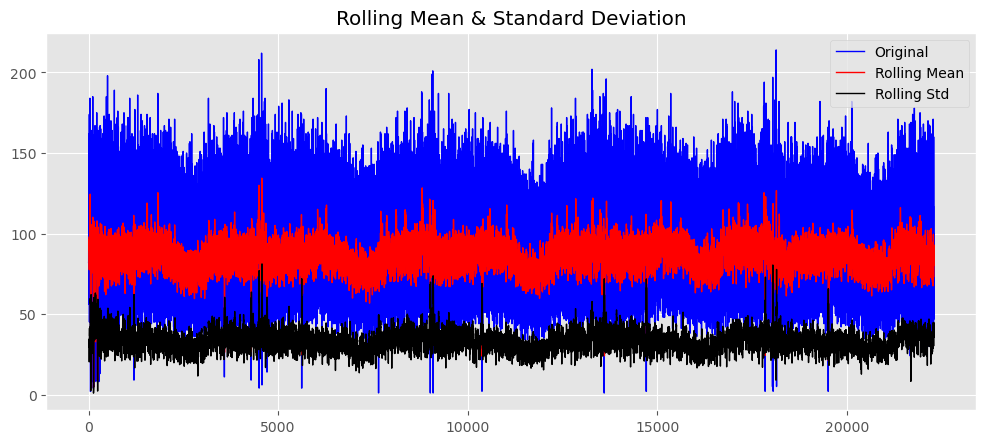

Results of Dickey-Fuller Test:
Test Statistic                -1.376772e+01
p-value                        9.813070e-26
#Lags Used                     4.700000e+01
Number of Observations Used    2.225700e+04
Critical Value (1%)           -3.430644e+00
Critical Value (5%)           -2.861670e+00
Critical Value (10%)          -2.566839e+00
dtype: float64


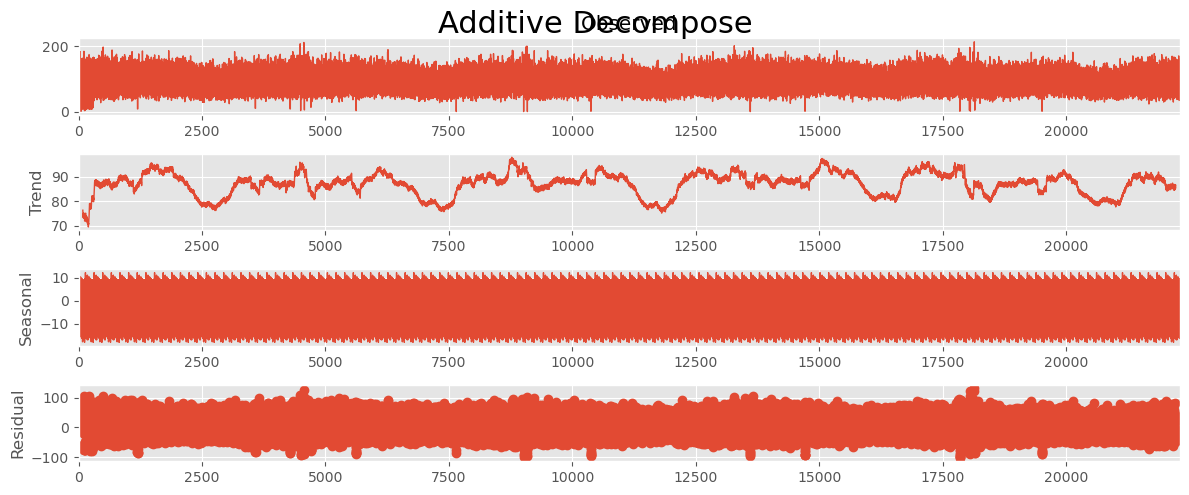

In [992]:
# Check components and stationarity of the forecast variable
forecast_variable = dataset['n_clients'].values

# Test stationarity
test_stationarity(forecast_variable)

# Additive Decomposition
result_add = seasonal_decompose(forecast_variable, model='additive', period=175)

# Plot components

result_add.plot().suptitle('Additive Decompose', fontsize=22)
pyplot.show()

In [993]:
values = dataset.values
# Encode weekday
if encode_weekday:
    encoder = LabelEncoder()
    values[:, 1] = encoder.fit_transform(values[:, 1])

# ensure all data is float
values = values.astype('float32')

print(values.shape)

(22305, 1)


In [994]:
# split into train and test, leave the last test_set blocks for n_output timesteps
train, test = values[:-test_set*iterations], values[-test_set*iterations:]  

# Normalization
scaler = StandardScaler() #MinMaxScaler(feature_range=(0, 1)) 
train = scaler.fit_transform(train)
test = scaler.transform(test)

#for walkforward
def normalize_train(scaler, train):
    train = scaler.fit_transform(train)
    return train

# restructure into windows, for the sliding window method
train = array(split(train, len(train) / data_split))
test = array(split(test, len(test) / test_set))
print(train.shape, test.shape)

(21405, 1, 1) (1, 900, 1)


In [995]:
# convert history into inputs and outputs - framing to a supervised learning problem
def to_supervised(train, n_input, n_output, stride=1):
    # flatten data
    data = train.reshape(train.shape[0] * train.shape[1], train.shape[2])
    train_x, train_y = list(), list()
    in_start = 0
    # step over the entire history one STRIDE step at a time
    for _ in range(0, len(data), stride):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_output
        # ensure we have enough data for this instance
        if out_end <= len(data):
            """
            print("iteration")
            print("x")
            print(in_start,in_end)
            print("y")
            print(in_end,out_end)
            """
            train_x.append(data[in_start:in_end, :])
            train_y.append(data[in_end:out_end, 0])
        # move along stride time steps
        in_start += stride
    print(array(train_x).shape, array(train_y).shape)
    return array(train_x), array(train_y)

In [996]:
# make the multi-step forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    input_x = data.reshape(1, n_input, 1) # n_features = 1
    input_x = numpy.asarray(input_x).astype('float32')
    # print(input_x.shape)

    # forecast the next n_output steps
    yhat = model.predict(input_x, verbose=0)

    # we only want the forecast variable
    yhat = yhat[0]
    return yhat

In [997]:
# invert the scaling
def invTransformTarget(scaler, data):
    dummy = pd.DataFrame(zeros((len(data), scaler.n_features_in_)))
    dummy[0] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=dummy.columns)
    return dummy[0].values

walkforward expanding: 1
total expansions: 1
(21390, 15, 1) (21390, 1)
Epoch 1/150
669/669 [==============================] - 4s 6ms/step - loss: 0.2425 - mae: 0.3559
Epoch 2/150
669/669 [==============================] - 3s 5ms/step - loss: 0.1304 - mae: 0.2733
Epoch 3/150
669/669 [==============================] - 3s 5ms/step - loss: 0.1250 - mae: 0.2658
Epoch 4/150
669/669 [==============================] - 3s 5ms/step - loss: 0.1195 - mae: 0.2584
Epoch 5/150
669/669 [==============================] - 3s 4ms/step - loss: 0.1180 - mae: 0.2557
Epoch 6/150
669/669 [==============================] - 3s 4ms/step - loss: 0.1156 - mae: 0.2518
Epoch 7/150
669/669 [==============================] - 3s 5ms/step - loss: 0.1137 - mae: 0.2500
Epoch 8/150
669/669 [==============================] - 3s 5ms/step - loss: 0.1120 - mae: 0.2464
Epoch 9/150
669/669 [==============================] - 3s 5ms/step - loss: 0.1101 - mae: 0.2448
Epoch 10/150
669/669 [==============================] - 3s 5ms/st

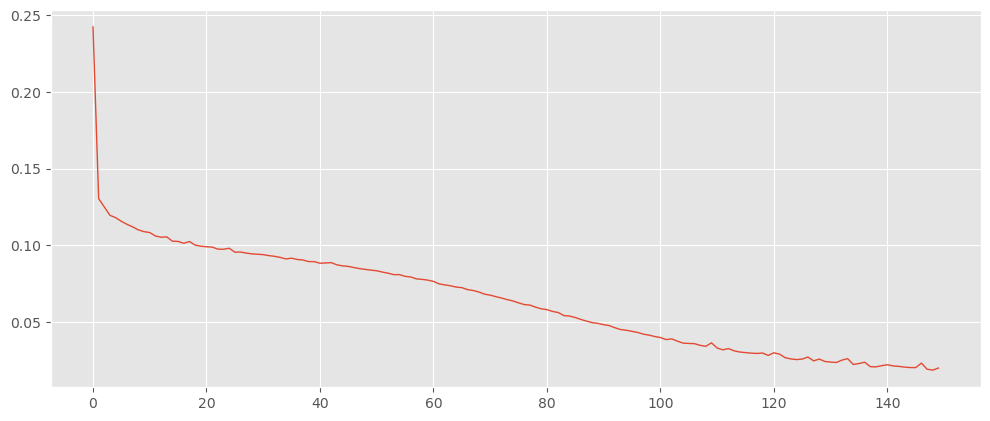

Test unnormalized error to compare to training loss:
0.23394843637474713
21405
The following errors are calculated without the imputed observations!



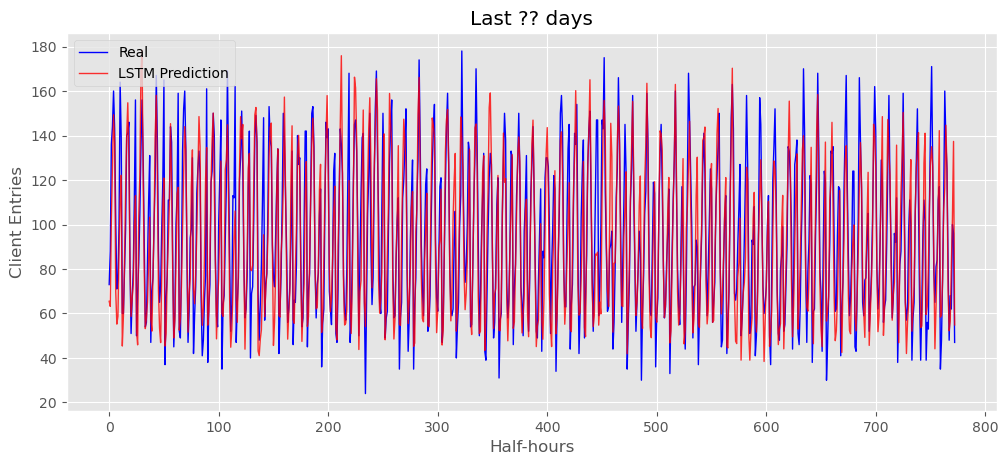

size of target and prediction:
773 773
Each n_output score, iteration 1 
RMSE 17.074291657107146
MAE 13.256509243850342
MAPE 15.353050125715734
MAAPE 14.841539510236204 
R2 0.7662149990503593 



"\nplot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')\nImage('model.png') \n# The question mark means that first dimension is not fixed in the graph and it can vary between run calls\n"

In [998]:
#%matplotlib notebook
# history of windows, is updated for each prediction
history = [x for x in train]


# Time Series CROSS-VALIDATION
# we don't need to retrain all the time though!
for i in range(iterations):
    yhat_sequence = list()
    print("walkforward expanding: %s" % (i+1))
    print("total expansions: %s" % (iterations))
    # the model is trained and retrained for every number of n_output to predict
    model = build_model(array(history), n_input, n_output, stride, batch_size=0)  
    train_size = len(history) # number of training windows
    len_train = train_size*test_set # actual training size/length
    if single_prediction:
            len_train = train_size
    # predict the next n_output steps
    for j in range(test_set):
        if j==0:
            inp = array(history).flatten()[-n_input:]
            yhat = forecast(model, inp, n_input)
        else:
            inp = inp.flatten()[-n_input:]
            yhat = forecast(model, inp, n_input)
        inp = numpy.append(inp, yhat.item(0))
        #print(yhat.shape)
        yhat_sequence = array(yhat_sequence)
        yhat_sequence = numpy.append(yhat_sequence, yhat.item(0))
        #print(yhat_sequence)

    print("Test unnormalized error to compare to training loss:") 
    #print(array(test).shape, len(yhat_sequence))
    #print(array(test[:test_set*(i+1)]).shape)
    print(mean_squared_error(array(test[i, :, 0]).flatten(), yhat_sequence))

    # invert the scaling on predictions
    yhat_sequence = invTransformTarget(scaler, yhat_sequence)
    yhat_sequence = yhat_sequence.tolist()

    # invert scaling for real values
    test_y = invTransformTarget(scaler, array(test[i, :, 0]).flatten())
    
    
    if walkforward:
        history.append(test[i, :])
        arr_history = array(history)
        n_windows = arr_history.shape[0]
        arr_history = invTransformTarget(scaler, arr_history.flatten())
        arr_history = arr_history.reshape(n_windows*test_set,n_features)
        arr_history = normalize_train(scaler, arr_history)
        history = list(arr_history.reshape(n_windows, test_set, n_features))

    if imputed:
        print(len_train)
        list_idx = []
        for idx in imputed_idx:
            if len_train-1<idx<len_train+test_set:
                    list_idx.append(idx - len_train)
        if list_idx:
            yhat_sequence = numpy.delete(yhat_sequence,  list_idx)
            test_y = numpy.delete(test_y,  list_idx)  
            print("The following errors are calculated without the imputed observations!\n")

    if compare_imputed:
        list_idx = []
        for idx in remove_idx:
            if len_train-1<idx<len_train+test_set:
                list_idx.append(idx - len_train)
        if list_idx:
            yhat_sequence = numpy.delete(yhat_sequence,  list_idx)
            test_y = numpy.delete(test_y,  list_idx) 
            print("The following errors are calculated without observations that do not fit into the wanted schedule!\n")
            print(list_idx)

    # plot each iteration 
    #print(yhat_sequence)
    pyplot.title('Last ?? days')
    pyplot.plot(test_y, color="blue", label="Real")
    pyplot.plot(yhat_sequence, alpha=0.8, color="red", label="LSTM Prediction")
    pyplot.legend(loc="upper left")
    pyplot.xlabel("Hours")
    pyplot.ylabel("Client Entries")
    pyplot.show()

    print("size of target and prediction:")
    print(len(test_y), len(yhat_sequence))
    # Score only from the each modelled n_output
    rmse = sqrt(mean_squared_error(test_y, yhat_sequence))
    mae = mean(abs(test_y - yhat_sequence))
    mape = mean(abs(test_y - yhat_sequence) / test_y) * 100
    maape = mean_arctangent_absolute_percentage_error(test_y, yhat_sequence)
    r2 = r2_score(test_y, yhat_sequence)
    print('Each n_output score, iteration %s \nRMSE %s' % (i+1, rmse))
    print('MAE %s' % (mae))
    print('MAPE %s' % (mape))
    print('MAAPE %s ' % (maape))
    print('R2 %s \n' % (r2))
"""
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png') 
# The question mark means that first dimension is not fixed in the graph and it can vary between run calls
"""